In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

In [4]:
io = IOBuffer(append=true)
print(io, @sprintf "\nData & \$\\mx\$ & \$\\mn\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
    print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "\$10^{-7}\$ & ")
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f \\\\ \n" result.fit.param[4])
end

VLFResultsLatex (generic function with 1 method)

# Viral load data fitting

Macaque monkies data from

*Chandrashekar, A., Liu, J., Martinot, A. J., McMahan, K., Mercado, N. B., Peter, L., Tostanoski, L. H., Yu, J., Maliga, Z., Nekorchuk, M., Busman-Sahay, K., Terry, M., Wrijil, L. M., Ducat, S., Martinez, D. R., Atyeo, C., Fischinger, S., Burke, J. S., Slein, M. D., … Barouch, D. H. (2020). SARS-CoV-2 infection protects against rechallenge in rhesus macaques. Science, 817(August), eabc4776. https://doi.org/10.1126/science.abc4776*


## Data set

3 data sets from nasal swab (NS) samples with 10 observations and 3 data sets from 3 data sets from bronchoalveolar lavage (BAL) with 7 observations, each with 3 individuals.

In [5]:
RAWDATA = Dict()
path = "../../data/Chandrashekar2020/"
foreach(filter(x->occursin(".csv", x), readdir(path))) do file
    temp = readdlm(path*file, ',', Float64, '\n', header=true)
    RAWDATA[file[1:end-4]] = DataFrame(temp[1], Symbol.(temp[2][:]))
end
for k in keys(RAWDATA)
    display("Data: "*k)
    display(RAWDATA[k])
end

"Data: Group 3 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,5.57957,6.78347,6.52007,5.68887,5.00241,3.71236,3.99145,1.69897,1.69897
2,1.69897,3.73932,5.05975,2.46123,1.69897,1.69897,1.69897,1.69897,1.69897,1.69897
3,1.69897,3.60011,6.78389,5.70977,6.19306,5.36131,2.80269,1.69897,1.94787,1.69897


"Data: Group 1 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.4688,8.16525,6.23715,5.12414,3.3126,1.69897,1.69897
2,4.14981,5.00692,5.32055,2.65836,1.69897,1.69897,1.69897
3,6.26342,5.88252,3.67602,1.99093,1.69897,1.69897,1.69897


"Data: Group 2 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.8212,6.5641,3.83382,3.22656,2.16679,1.69897,1.69897
2,5.73113,7.31209,4.65007,4.31562,2.06809,2.82957,1.69897
3,8.02753,8.96746,6.95217,5.19312,4.95855,1.69897,1.69897


"Data: Group 2 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,4.6673,6.9958,6.4588,6.55061,5.1867,3.30582,2.85234,1.69897,1.69897
2,1.69897,7.08751,7.09246,5.72399,5.83477,3.66631,3.62261,1.69897,1.69897,1.69897
3,1.69897,6.33338,8.16723,7.13837,5.33877,2.94954,1.69897,1.69897,1.69897,1.69897


"Data: Group 1 (NS)"

,0,1,2,4,7,10,14,21,28,35
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69897,7.43565,7.85023,6.96461,6.20642,5.21971,4.42147,3.39755,2.65476,1.69897
2,1.69897,6.92311,8.54628,6.57286,6.20234,3.89381,3.59259,2.33387,2.11574,1.69897
3,1.69897,6.62817,6.34402,5.29559,1.69897,2.97788,1.69897,1.69897,1.69897,1.69897


"Data: Group 3 (BAL)"

,1,2,4,7,10,14,21
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.15544,4.71935,3.45758,5.38309,4.78797,4.47411,1.69897
2,5.29566,7.90372,4.85545,4.21351,1.69897,1.69897,1.69897
3,5.725,5.74933,4.52692,3.91309,1.69897,1.69897,1.69897


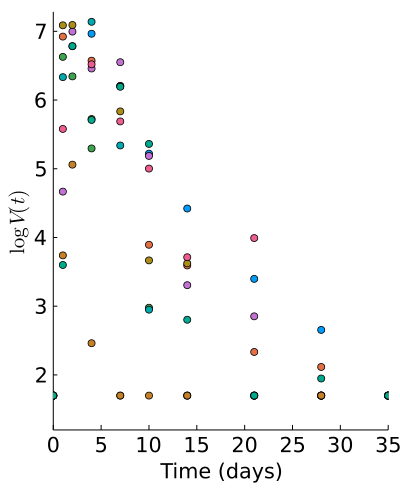

In [6]:
plt = plot(legend=:none)
for dataname in ["Group 1 (NS)", "Group 2 (NS)", "Group 3 (NS)"]
    for monkey in [1, 2, 3]
        ttdata = parse.(Float64, names(RAWDATA[dataname]))
        vvdata = Array(RAWDATA[dataname])[monkey, :]
        data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
        plot!(plt, data, size = (400, 500))
    end
end
savefig(figdir*"Chandrashekar2020Data.pdf")
display(plt)

## Fitting the standard virus load function to each individual in all groups (nasal swab)

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

Group 1 (NS), monkey no.: 1
RSS = 1.40722e+00 (convergence: true)


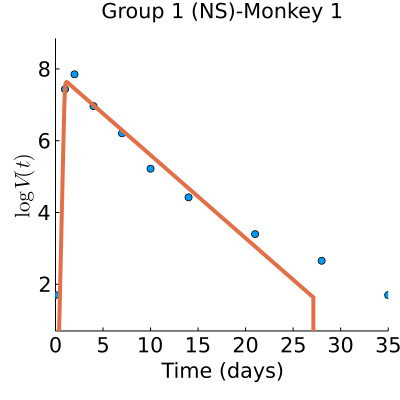

  a₁ = 7.549e-01 (initial=7.102e-01)
  a₂ = 1.205e+00 (initial=1.251e+00)
  b₁ = 2.713e+01 (initial=2.364e+01)
  b₂ = 2.713e+01 (initial=3.062e+01)
  α = 5.331e-01 (initial=8.000e-01)
  logVmax = 7.636e+00 (initial=7.800e+00)





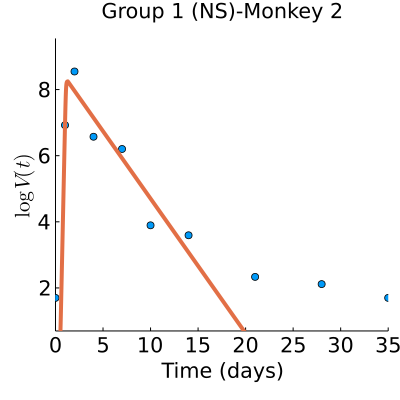

Group 1 (NS), monkey no.: 2
RSS = 2.24921e+00 (convergence: true)
  a₁ = 9.018e-01 (initial=5.090e-02)
  a₂ = 1.295e+00 (initial=2.281e+00)
  b₁ = 2.363e+01 (initial=1.306e+01)
  b₂ = 2.849e+01 (initial=3.421e+01)
  α = 9.378e-01 (initial=8.000e-01)
  logVmax = 8.248e+00 (initial=7.800e+00)





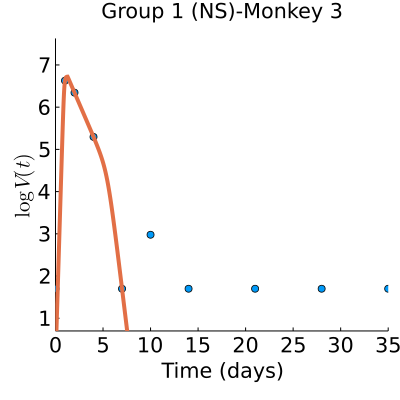

Group 1 (NS), monkey no.: 3
RSS = 1.63562e+00 (convergence: true)
  a₁ = 5.637e-01 (initial=3.280e-01)
  a₂ = 1.272e+00 (initial=2.097e+00)
  b₁ = 3.525e+00 (initial=4.953e+00)
  b₂ = 7.430e+00 (initial=8.520e+00)
  α = 1.202e+00 (initial=8.000e-01)
  logVmax = 6.724e+00 (initial=7.800e+00)





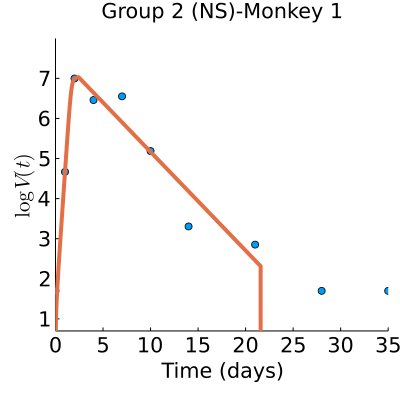

Group 2 (NS), monkey no.: 1
RSS = 1.37370e+00 (convergence: true)
  a₁ = 9.289e-01 (initial=8.339e-02)
  a₂ = 2.434e+00 (initial=4.123e+00)
  b₁ = 2.159e+01 (initial=1.821e+01)
  b₂ = 2.159e+01 (initial=2.497e+01)
  α = 5.668e-01 (initial=8.000e-01)
  logVmax = 7.029e+00 (initial=7.800e+00)



Group 2 (NS), monkey no.: 2
RSS = 3.07612e+00 (convergence: false)


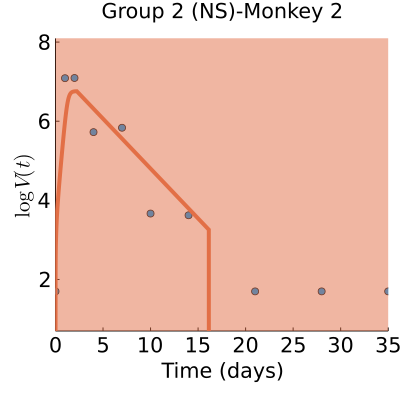

  a₁ = 2.795e-01 (CI=(-1.359e+02, 1.364e+02), initial=4.321e-01)
  a₂ = 2.241e+00 (CI=(-1.747e+02, 1.792e+02), initial=4.050e+00)
  b₁ = 1.614e+01 (CI=(-5.466e+13, 5.466e+13), initial=9.481e+00)
  b₂ = 1.614e+01 (CI=(-5.466e+13, 5.466e+13), initial=2.279e+01)
  α = 5.803e-01 (CI=(-1.774e-01, 1.338e+00), initial=8.000e-01)
  logVmax = 6.759e+00 (CI=(-3.874e+01, 5.226e+01), initial=7.800e+00)





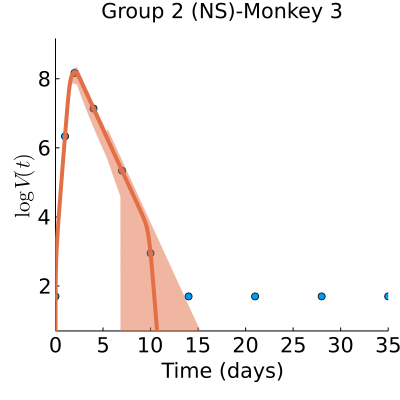

Group 2 (NS), monkey no.: 3
RSS = 2.36658e-30 (convergence: true)
  a₁ = 7.803e-01 (CI=(7.803e-01, 7.803e-01), initial=5.556e-01)
  a₂ = 2.269e+00 (CI=(2.269e+00, 2.269e+00), initial=2.071e+00)
  b₁ = 8.930e+00 (CI=(-1.751e+01, 3.536e+01), initial=2.786e+00)
  b₂ = 1.075e+01 (CI=(-7.747e+00, 2.924e+01), initial=1.540e+01)
  α = 1.381e+00 (CI=(1.381e+00, 1.381e+00), initial=8.000e-01)
  logVmax = 8.177e+00 (CI=(8.177e+00, 8.177e+00), initial=7.800e+00)





Group 3 (NS), monkey no.: 1
RSS = 1.26373e+00 (convergence: true)
  a₁ = 9.414e-01 (CI=(-8.067e+15, 8.067e+15), initial=8.131e-01)
  a₂ = 1.144e+00 (CI=(-1.937e+16, 1.937e+16), initial=1.149e+00)
  b₁ = 2.283e+01 (CI=(-1.983e+12, 1.983e+12), initial=1.839e+01)
  b₂ = 2.283e+01 (CI=(-1.983e+12, 1.983e+12), initial=2.728e+01)
  α = 3.861e-01 (CI=(1.143e-01, 6.578e-01), initial=8.000e-01)
  logVmax = 6.712e+00 (CI=(-3.247e+15, 3.247e+15), initial=7.800e+00)





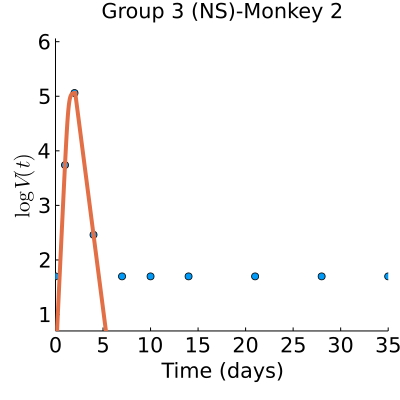

Group 3 (NS), monkey no.: 2
RSS = 3.94430e-31 (convergence: true)
  a₁ = 6.409e-01 (initial=1.550e+00)
  a₂ = 2.076e+00 (initial=2.370e+00)
  b₁ = 1.659e+01 (initial=4.025e+00)
  b₂ = 3.500e+01 (initial=2.952e+01)
  α = 3.112e+00 (initial=8.000e-01)
  logVmax = 5.062e+00 (initial=7.800e+00)





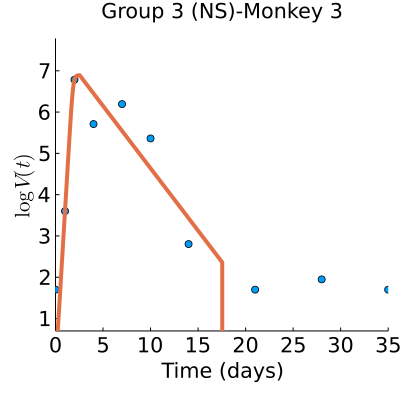

Group 3 (NS), monkey no.: 3
RSS = 1.94785e+00 (convergence: true)
  a₁ = 1.179e+00 (initial=1.212e+00)
  a₂ = 2.538e+00 (initial=1.671e+00)
  b₁ = 1.755e+01 (initial=1.267e+01)
  b₂ = 1.755e+01 (initial=2.242e+01)
  α = 6.958e-01 (initial=8.000e-01)
  logVmax = 6.894e+00 (initial=7.800e+00)




Data & $\mx$ & $\mn$ & $a_1$ & $a_2$ & $\alpha$ & $b_1$ & $b_2$ \\ 
Group 1 (NS) monkey 1 & 4.32 $\cdot 10^{7}$ & $10^{-7}$ & 0.75 & 1.20 & 0.53 & 27.13 & 27.13 \\ 
Group 1 (NS) monkey 2 & 1.77 $\cdot 10^{8}$ & $10^{-7}$ & 0.90 & 1.30 & 0.94 & 23.63 & 28.49 \\ 
Group 1 (NS) monkey 3 & 5.30 $\cdot 10^{6}$ & $10^{-7}$ & 0.56 & 1.27 & 1.20 & 3.53 & 7.43 \\ 
Group 2 (NS) monkey 1 & 1.07 $\cdot 10^{7}$ & $10^{-7}$ & 0.93 & 2.43 & 0.57 & 21.59 & 21.59 \\ 
Group 2 (NS) monkey 2 & 5.74 $\cdot 10^{6}$ & $10^{-7}$ & 0.28 & 2.24 & 0.58 & 16.14 & 16.14 \\ 
Group 2 (NS) monkey 3 & 1.50 $\cdot 10^{8}$ & $10^{-7}$ & 0.78 & 2.27 & 1.38 & 8.93 & 10.75 \\ 
Group 3 (NS) monkey 1 & 5.15 $\cdot 10^{6}$ & $10^{-7}$ &

6×9 Matrix{Any}:
  0.754879   0.901755  0.56368   0.928858   0.279493   0.78028   0.941428   0.64085   1.17931
  1.20489    1.29502   1.27158   2.43405    2.24098    2.26931   1.14404    2.07564   2.53836
 27.1333    23.6341    3.52516  21.5877    16.1358     8.92986  22.8336    16.5858   17.5488
 27.1333    28.4867    7.43035  21.5877    16.1358    10.7487   22.8336    34.9995   17.5488
  0.533066   0.937787  1.20176   0.56683    0.580303   1.38125   0.386057   3.11166   0.695761
  7.63563    8.24799   6.72421   7.02878    6.75866    8.17656   6.71203    5.06177   6.89365

In [7]:
params = []
for dataname in ["Group 1 (NS)", "Group 2 (NS)", "Group 3 (NS)"]
    for monkey in [1, 2, 3]
        ttdata = parse.(Float64, names(RAWDATA[dataname]))
        vvdata = Array(RAWDATA[dataname])[monkey, :]
        data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
        resultVLF = nothing
        for iter = 1:1000
            #       a₁,   a₂,   b₁,   b₂,           α,    logVmax
            par0 = vcat(sort(data.t[end]*rand(4)), [0.80, 7.8])
            result = try 
                VirusLoadCurve.fitVLF(data, par0)
            catch y
                nothing
            end
            if result != nothing
                if resultVLF == nothing
                    resultVLF = result
                else
                    if sum(abs2, result.fit.resid) < sum(abs2, resultVLF.fit.resid)
                        resultVLF = result
                    end
                end
            end
        end
        params = vcat(params, resultVLF.fit.param)
        println(dataname, ", monkey no.: ", monkey)
        summary(resultVLF)
        VLFResultsLatex(dataname*" monkey "*string(monkey), resultVLF)
        pt = plot(data)
        plot!(pt, resultVLF)
        plot!(pt, legend=false)
        title!(pt, dataname*"-Monkey "*string(monkey))
        savefig(figdir*"Chandrashekar2020-"*dataname*"-"*string(monkey)*".png")
        savefig(figdir*"Chandrashekar2020-"*dataname*"-"*string(monkey)*".pdf")
        display(pt)
        println("\n\n")
    end
end
print(read(io, String))
params = reshape(params, (6, 9))

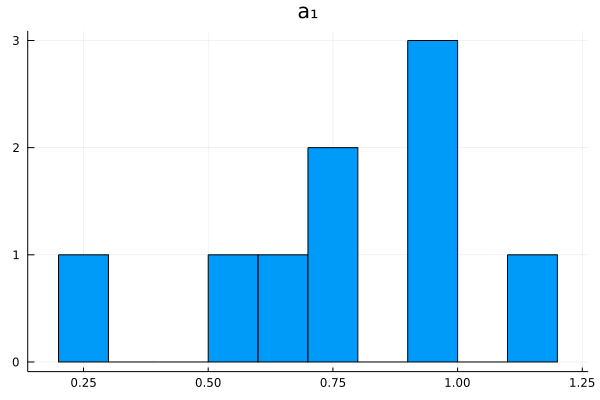

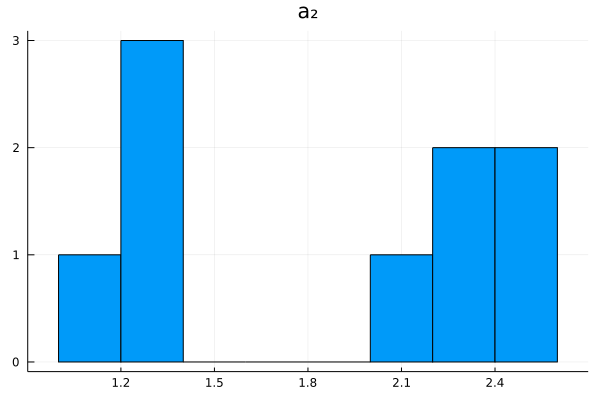

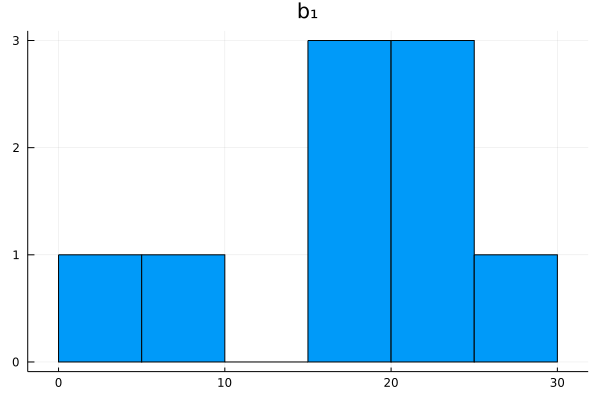

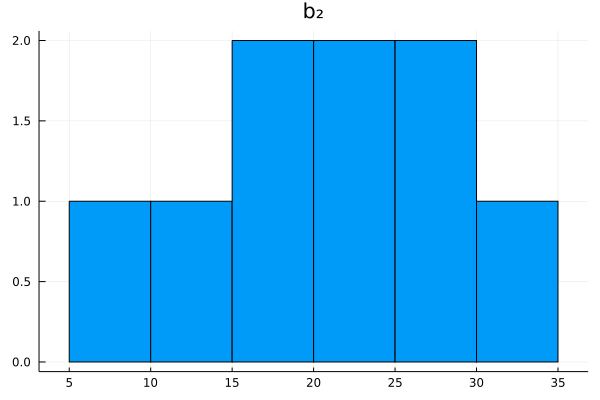

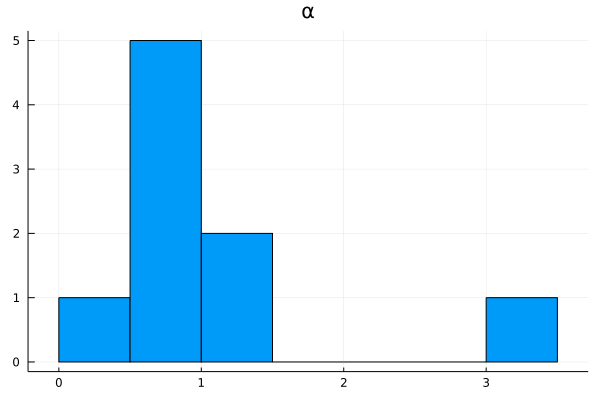

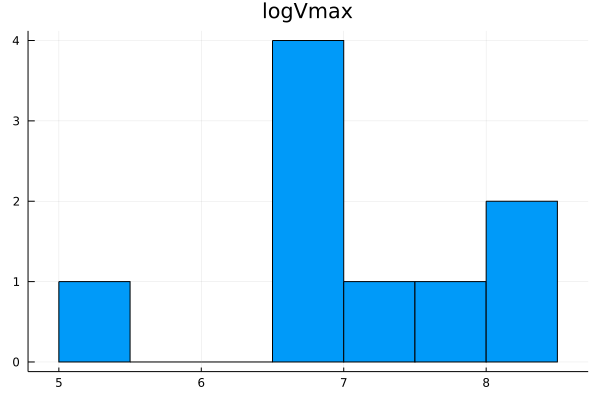

6-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [8]:
parnames = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"]
[display(histogram(params[i, :], bins=9, leg=false, title=parnames[i])) for i in 1:6]